# Satellite Imagery Object Detection

*This notebook assumes Kubeflow 1.2 was installed on Red Hat OpenShift 4.6 and is running a tf-notebook-image-v0.7.0.*

Satellite accessibility has generated an amount of data that has outgrown the ability to manually and heuristically extract value. Automating analysis using Machines Learning framework and models offers incredible accuracy, speed and value across numerous use cases. 

This notebook was inspired by a Kaggle competition and updated with new libraries and toolkits that further extend it's development and prediction. 

The model utilizes a supervised learning approach with a Keras sequential model that can run on CPUs (and even better on GPUs). Keras is an open-source deep learning library written in Python. tf.keras is a submodule inside of TensowFlow 2.0. TensorFlow deep learning library (TensorFlow 2) that integrated the Keras API directly. Overall, it is a simple list of layers; limited to a single input, single output layer stack. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.

Concretely, this notebook adheres to a common ML Lifecycle:

1. Define the Problem.
1. Identify the Solution.
1. Load and Prepare Data.
1. Create the Model.
1. Train the Model.
1. Deploy the Model. 
1. Infere and Observe.

Dataset: https://www.kaggle.com/rhammell/ships-in-satellite-imagery

## Define the Problem: Satellite Imagery Ship Detection

We need an automated and efficient way to identify ships and their location in route satellite imagery updates from the Panama Canal. Solution success will be based upon accuracy of ship identification in N satellite images and expanded to other to naval areas of interests.

## Define the Solution: Deep Learning

Under Deep Learning, Object detection algorithms are a method of recognizing objects in images or video in Computer Vision, and implemented in fields from self-driving cars, facial recognition, and disease detection systems. The model is tasked with localizing the objects present in an image, and at the same time, classifying them into different categories. Learn more at [Object Detection with RetinaNet](https://keras.io/examples/vision/retinanet/). 

### Notebook Setup

Often time, the image that the Jupyter Notebook was created from doesn't include all of the tools, libraries, versions and dependencies a Data Engineer and/or Data Scientists needs to do their work. Installs, imports and upgrades get a containerized notebook to a state that encapsulated, repeatable, and portable.

In [7]:
### Import and Check TensorFlow and Keras versions
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


In [42]:
### Install necessary software and libraries
# Upgrade pip
!pip install --upgrade pip --no-warn-script-location --user
# TF is out of date on the default notebook, upgrade to TF2 in the notebook. --no-warn-script-location to supress warning messages
!pip3 install tensorflow==2.3.0 --no-warn-script-location
# TF2 includes Keras, upgrading pulls in new libraries and algorithms
!pip3 install keras --no-warn-script-location
# Python archiver that enables inflating the dataset from xz and other formats
!pip install patool --no-warn-script-location
# Pythong library for data engineering
!pip3 install pandas
# Python library for static, animated and interactive data visualizations
!pip install matplotlib --no-warn-script-location
# Python imaging library adding image processing 
!pip install Pillow --no-warn-script-location

# TensorFlow2
import tensorflow as tf

# Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

# Compress/Decompress Files
import patoolib

# Python module path to check if files exists
import os.path

# Pandas library for Data Analysis and Manipulation
import pandas as pd

# Pillow
from PIL import Image, ImageDraw 

# Linear Algebra
import numpy as np

# Data visualizations within the notebook
from matplotlib import pyplot as plt

# Offers classes representing filesystem paths with semantics appropriate for different operating systems.
import pathlib

# System-specific parameters and functions
import sys

# pseudo-random number generators for various distros
import random

# Python provides a built-in module called json for serializing and deserializing objects.
import json

print(tf.__version__)
print(keras.__version__)

print('Setup complete.')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.

In [9]:
# Create a requirements.txt aside from uploading a jupyter image
# pip freeze > requirements.txt

## Load and Prepare the Data

TensorFlow 2 now incorporates the Keras API, which is a deep learning framework. [Keras includes known datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) by default that can be imported for exploring data science methods. 

The dataset used is available from Kaggle, ["Ships in Satellite Imagery"](https://www.kaggle.com/rhammell/ships-in-satellite-imagery), which is a great place to find datasets and other AI resources. Kaggle also hosts competitions, which are an exciting way to get involved in the community.

### Download the dataset

The Kaggle dataset was downloaded as an archive.zip file, compressed with a bzip2 and uploaded to a github for demonstration purposes

In [45]:
# This cell check if the file exists or not using the is.path module before downloading and extracting
# If the file doesn't exists in the working path, it performs a wget
# -nc parameter is a no clobber that skips the download if the file exists
# raw=true removes the github HTML wrapper
# patool lib supports various compression formats. https://pypi.org/project/patool/ http://wummel.github.io/patool/
# prints a message for the logical action
checkFile = "./shipsnet.json"

if os.path.isfile(checkFile):
    print("File Exists.")
else:
    !wget -nc --no-check-certificate https://github.com/dmarcus-wire/satellite-ship-detection/blob/master/dataset/shipsnet.json.bz2?raw=true -O shipsnet.json.bz2
    patoolib.extract_archive("shipsnet.json.bz2")
    print("File Imported and Extracted.")

File Exists.


### Explore the data

The dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.

In [43]:
# pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

data = pd.read_json('./shipsnet.json')
print(data)

                                                   data  labels  \
0     [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1     [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2     [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3     [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4     [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   
...                                                 ...     ...   
3995  [126, 122, 124, 138, 165, 186, 195, 199, 203, ...       0   
3996  [130, 134, 139, 128, 117, 126, 141, 147, 142, ...       0   
3997  [171, 135, 118, 140, 145, 144, 154, 165, 139, ...       0   
3998  [85, 90, 94, 95, 94, 92, 93, 96, 93, 94, 94, 9...       0   
3999  [122, 122, 126, 126, 142, 153, 174, 190, 185, ...       0   

                                      locations             scene_ids  
0       [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1       [-122.33222866289329, 37.7491755586813]  20

In [35]:
# Load the inflated file data
f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

# The input_data is a layer that will be used as the input layer to your network. 
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

In [46]:
# Because the training data is known and labelled, the input_data contains over 4000 images images 
# Each image is represented in a 19200 vector length
input_data.shape

(4000, 19200)

In [81]:
# How many images are ships vs. not ships; 0 = no ship; # 1 = tagged "ship"
# 3000 = no-ship 
# 1000 = ship
np.bincount(output_data)

array([3000, 1000])

In [50]:
# images are represented as a collection of unsigned 8-bit integer values between 0 and 255
input_data.dtype

dtype('uint8')

In [55]:
# images range min value
input_data.min()

1

In [56]:
# image range max value
input_data.max()

255

In [57]:
# A different printout of the input_data array
input_data[0]

array([82, 89, 91, ..., 86, 88, 89], dtype=uint8)

### Visualize the data

JSON data is great for enabling a computer to see the images, it's not so easy for a human.  We can reshape the data in order to get a better understanding. This is also done to convert multi-dimensional images to a vector.

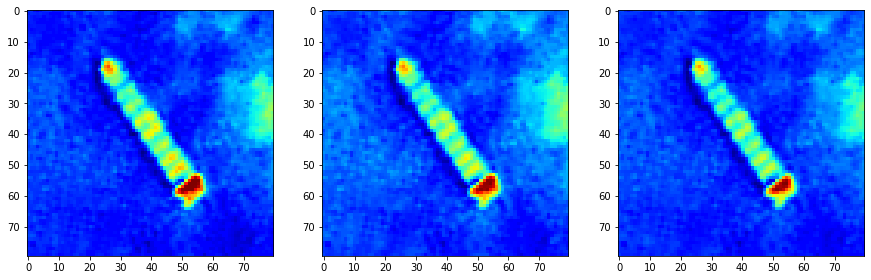

In [73]:
n_spectrum = 3 # RGB color channels
weight = 80 # 80 x 80 image
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X[0].shape

# Dataset image
pic = X[1] # << CHANGE VALUE TO PLOT DIFF IMAGES

red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectrum = pic[2]

plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# Plot each RGB channel
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)
plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)
plt.subplot(1, 3, 3)
plt.imshow(blue_spectrum)
plt.show()

## Create training data

Keras provides a utility to categorically encode values.

In [83]:
# Categorically encode the labels
y = np_utils.to_categorical(output_data, 2)

In [85]:
# Shuffle the indexes so the model doesn't learn the data per vector
indexes = np.arange(4000)
np.random.shuffle(indexes)

In [86]:
# Create the training data
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [94]:
# Here are the first 10 values of the training labels, which you can see have now been categorically encoded:
X_train[0:9]

array([[[[1.        , 0.96078431, 0.9372549 ],
         [1.        , 0.96078431, 0.94117647],
         [1.        , 0.96078431, 0.94117647],
         ...,
         [0.79607843, 0.77254902, 0.70196078],
         [0.80392157, 0.76078431, 0.67058824],
         [0.85098039, 0.77647059, 0.6627451 ]],

        [[1.        , 0.96470588, 0.91764706],
         [1.        , 0.96078431, 0.93333333],
         [1.        , 0.96078431, 0.9372549 ],
         ...,
         [0.59607843, 0.56470588, 0.4745098 ],
         [0.56078431, 0.52941176, 0.40784314],
         [0.6627451 , 0.59607843, 0.4627451 ]],

        [[0.96862745, 0.90980392, 0.83137255],
         [1.        , 0.95294118, 0.90196078],
         [1.        , 0.95686275, 0.91764706],
         ...,
         [0.3254902 , 0.31764706, 0.24313725],
         [0.38039216, 0.35294118, 0.24705882],
         [0.4745098 , 0.42352941, 0.32156863]],

        ...,

        [[0.85490196, 0.82352941, 0.76862745],
         [0.7372549 , 0.70588235, 0.62745098]

## Normalize the data 

Deep learning models operator better with floating point numbers between 0 and 1. RGB  values range from 0 to 255, so dividing all the pixel values of an image by 255 converts integer values to floating point values between 0 and 1 is called normalization. 

In [87]:
# Normalize the RGB data
X_train = X_train / 255

In [89]:
# Converted data type
X_train.dtype

dtype('float64')

In [90]:
# Image range min value
X_train.min()

0.00392156862745098

In [91]:
# Image range max value
X_train.max()

1.0

## Create the Model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. A Sequential model is not appropriate when:

Your model has multiple inputs or multiple outputs
Any of your layers has multiple inputs or multiple outputs
You need to do layer sharing
You want non-linear topology (e.g. a residual connection, a multi-branch model)

Source: https://www.tensorflow.org/guide/keras/sequential_model

In [98]:
# Initialize a random seed function to determine the sequence of random numbers. This helps with simulating and modelling
np.random.seed(42)

In [99]:
# Model Design and Layers
model = Sequential()

### Model Layers and Algorithms

Choosing the correct number of neurons is what puts the "science" in "data science" as it is a matter of capturing the statistical complexity of the dataset. 

Conv2D
Padding
Input Shape
Activation Function = relu
MaxPooling2D
Dropout

In [100]:
# Input Layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

# Hidden Layers

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output Layer - This layer uses the activation function softmax which will result in each of the layer's values being a probability between 0 and 1 and will result in all the outputs of the layer adding to 1. In this case, since the network is to make a guess about a single image belonging to 1 of 10 possible categories, there will be 10 outputs.
model.add(Dense(2, activation='softmax'))

### Summarize the Model

Keras provides the model instance method summary which will print a readable summary of a model:

In [101]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 32)       

### Compile the Model

Before we can actually train our model with data is to compile it. We use a loss function to help the model understand how well it is performing during training. We also specify that we would like to track accuracy while the model trains.

In [106]:
# optimization setup
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

NameError: name 'adams' is not defined

### Train the Model

Now that we have prepared training data, and a model, it's time to train our model with our training data, and verify it with its validation data. When fitting (training) a model with Keras, we use the model's fit method. It expects the following arguments:

The training data
The labels for the training data
The number of times it should train on the entire training dataset (called an epoch)
The validation or test data, and its labels

In [105]:
# training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2, # 20% of the data should be used only for validation
    shuffle=True,
    verbose=2)

Epoch 1/10
100/100 - 5s - loss: 0.0244 - accuracy: 0.9925 - val_loss: 0.0584 - val_accuracy: 0.9900
Epoch 2/10
100/100 - 5s - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0864 - val_accuracy: 0.9812
Epoch 3/10
100/100 - 5s - loss: 0.0245 - accuracy: 0.9922 - val_loss: 0.0706 - val_accuracy: 0.9825
Epoch 4/10
100/100 - 6s - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.1135 - val_accuracy: 0.9688
Epoch 5/10
100/100 - 5s - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0779 - val_accuracy: 0.9800
Epoch 6/10
100/100 - 5s - loss: 0.0168 - accuracy: 0.9950 - val_loss: 0.0806 - val_accuracy: 0.9800
Epoch 7/10
100/100 - 6s - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0884 - val_accuracy: 0.9787
Epoch 8/10
100/100 - 5s - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.0754 - val_accuracy: 0.9812
Epoch 9/10
100/100 - 6s - loss: 0.0229 - accuracy: 0.9934 - val_loss: 0.0933 - val_accuracy: 0.9800
Epoch 10/10
100/100 - 6s - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.0773 - val_accuracy: 0.9800

## Observing Accuracy


For each of the epochs, 
- accuracy = how well the model did for the epoch on all the training data. 
- val_accuracy = how well the model did on the validation data, which if you recall, was not used at all for training the model.

With a validation accuracy over 92%, we are ready to deploy this model to detect objects on unseen satellite imagery or "Inference".

# Save the Mdodel

With a well trained model, saved to disk for this scenario, we can deploy it to make predictions in other notebooks.

In [137]:
model.save('./models/ships_model')

In [ ]:
## House keeping item to clear memory
#import IPython
#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)

# Inference

Load an image to run the model against. Images provided taken from Panama Canal Area https://earth.google.com/web/search/panama+canal/@8.84828179,-79.51707735,-0.75627665a,5515.17281073d,35y,-0h,0t,0r/data=CigiJgokCepuc-6U8vQ_EXify2JrxvQ_GVAo_Y707FlAIbWTzJ3F61lA


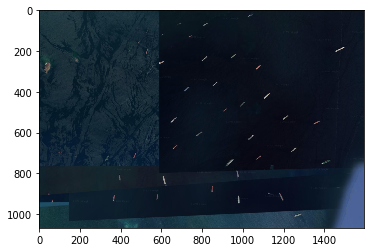

In [138]:
image = Image.open('./images/ships.png')
pix = image.load()

# Display image, but for use we need to make a vector
plt.imshow(image)

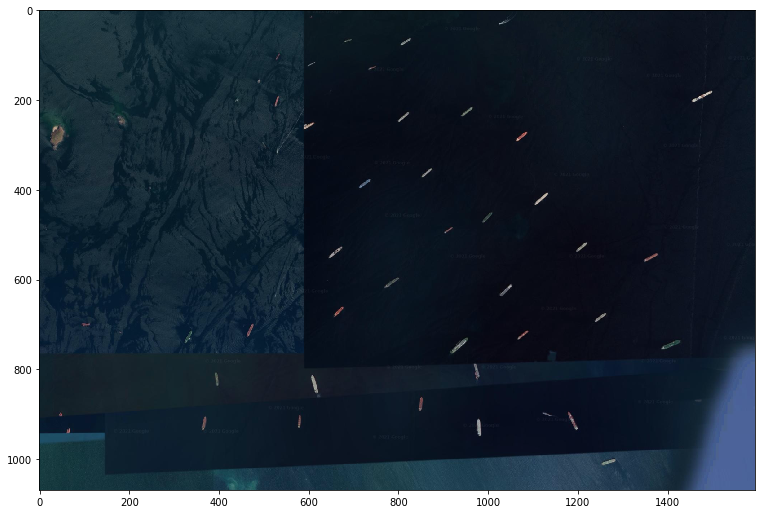

In [139]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)
plt.show()

In [125]:
picture_tensor = picture_tensor.transpose(2,0,1)

## Detect Ships on the image

In [133]:
picture_tensor = picture_tensor.transpose(2,0,1)

# Search on the image
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result
    
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:350 Y:90  [[0.01426478 0.98573524]]


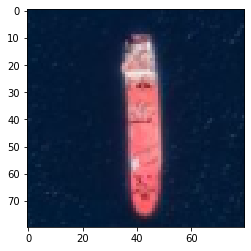

X:1220 Y:170  [[0.06828129 0.9317187 ]]


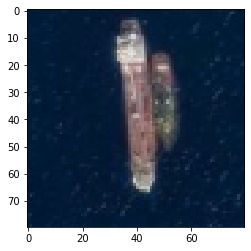

X:40 Y:350  [[0.08549965 0.9145003 ]]


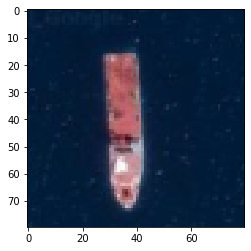

X:850 Y:560  [[0.02885655 0.9711435 ]]


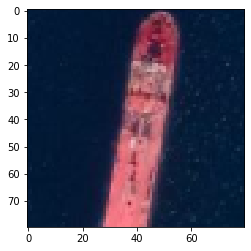

X:1040 Y:780  [[0.09699433 0.9030056 ]]


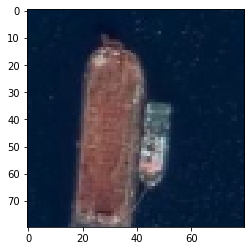

X:640 Y:870   [[1.35479095e-05 9.99986410e-01]]


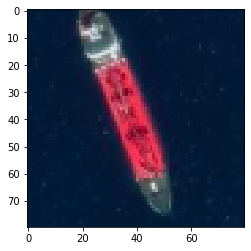

X:830 Y:970  [[0.05255572 0.94744426]]


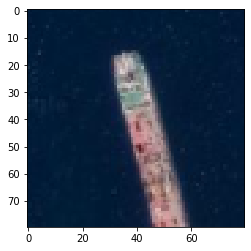

X:1530 Y:1000  

In [135]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

## Identify the Ships on the Image

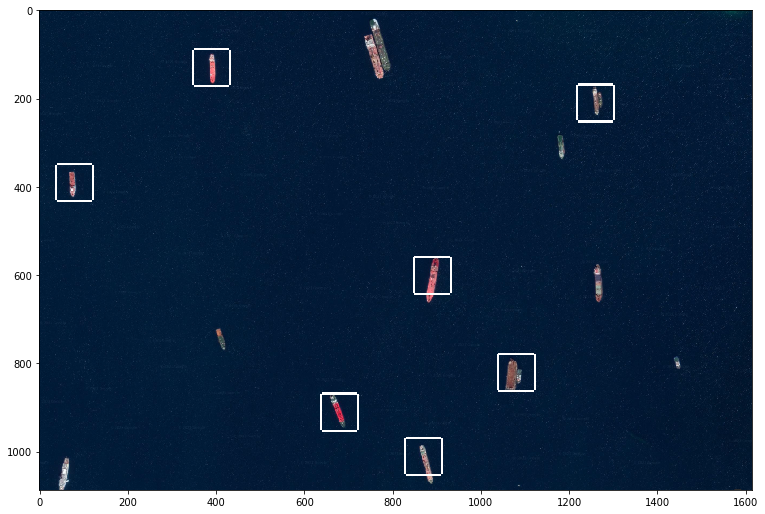

In [136]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
(1777, 2825, 3)
plt.figure(1, figsize = (15, 30))
plt.subplot(3,1,1)
plt.imshow(picture_tensor)
plt.show()